In [1]:
import sys
sys.path.insert(0, '../../')

In [2]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple, Union

import candle
import candle.functions as F
import experiments.trainingutils as tutils
import experiments.textgenutils as gutils

## (0) Contents

* [(1) Define Training Config](#(1)-Define-Training-Config)
* [(2) Load Tokenizer and Chat Template](#(2)-Load-Tokenizer-and-Chat-Template)
* [(3) Load Messenger chat data](#(3)-Load-Messenger-chat-data)
* [(4) Fine-Tune Model](#(4)-Fine-Tune-Model)
* [(5) Chat with JOHNaMA](#(5)-Chat-with-JOHNaMA)

## (1) Define Training Config

In [3]:
class Config:
    # Optimization configs
    
    ITERATIONS = 800  # Roughly 2 epochs
    WARMUP_STEPS = 40
    BATCH_SIZE = 10
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 0.0
    ADAM_BETAS = (0.9, 0.95)
    GRAD_CLIP_NORM = 1.0

    # Dashboard configs
    
    EVAL_ITERS = 5
    EVAL_BATCH_SIZE = 10
    EVAL_FRACTION = 0.1
    DASHBOARD_REFRESH_ITERS = 1
    SAMPLE_GENERATION_ITERS = 20

    # LoRA configs

    LORA_RANK = 8
    LORA_ALPHA = 16
    LORA_DROPOUT = 0.05
    

config = Config()

## (2) Load Tokenizer and Chat Template

In [4]:
MODEL_DIR = '/mnt/disks/disk1/llama2/'
tokenizer = candle.models.llama.LlamaTokenizer(os.path.join(MODEL_DIR, 'tokenizer.model'))
pad_id = tokenizer.sp_model.pad_id()

In [5]:
SYSTEM_MESSAGE = ('You are John Ma on a messenging app.')
chat_template = candle.nlp.chattemplates.LlamaChatTemplate(system_message=SYSTEM_MESSAGE)

## (3) Load Messenger chat data

In [6]:
with open('/home/johnma2006/candle/experiments/nlp_experiments/chats/messenger_chats.json', 'r' ) as f:
    messenger_chat_json = json.load(f)
messenger_chat_json = [[{'role': 'system', 'content': chat_template.system_message}] + m for m in messenger_chat_json]

chats = [chat_template.apply_chat_template(message, add_generation_prompt=False) for message in messenger_chat_json]

In [7]:
print('Random Message:\n')
print(np.random.choice(chats))

Random Message:

<s>[INST] <<SYS>>
You are John Ma on a messenging app.
<</SYS>>

nw no rush [/INST] Get ready. </s>


In [8]:
# Get train/test split

sentences = [tokenizer.encode(chat) for chat in chats]

test_i = np.random.choice(len(sentences), int(len(sentences) * config.EVAL_FRACTION), replace=False)
test_sentences = [sentences[i] for i in test_i]
train_sentences = [sentences[i] for i in range(len(sentences)) if i not in test_i]

print('# Train Sentences:', len(train_sentences))
print('# Test Sentences:', len(test_sentences))

# Train Sentences: 3939
# Test Sentences: 437


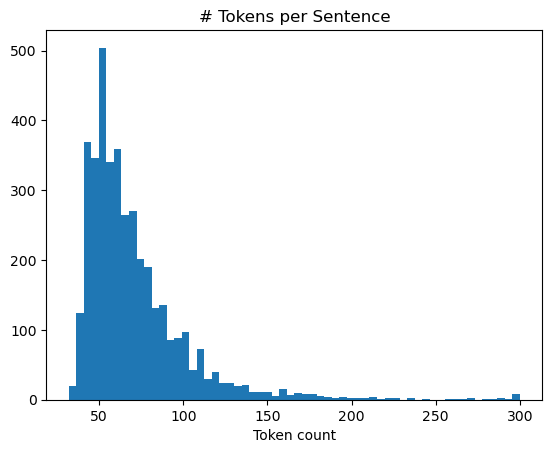

In [9]:
plt.hist([min(300, len(i)) for i in train_sentences], bins=60)
plt.title('# Tokens per Sentence')
plt.xlabel('Token count')
plt.show()

In [10]:
# Set truncation length based on the above histogram

TOKEN_TRUNCATION_LEN = 200

## (3) Define Model, Optimizer, and Scheduler

In [11]:
os.environ['TRANSFORMERS_CACHE'] = '/mnt/disks/disk1'

In [12]:
# Load pre-trained model

MODEL_SIZE = '7b-chat'
model = candle.models.llama.Llama.from_pretrained(MODEL_SIZE, MODEL_DIR)

/mnt/disks/disk1/miniconda3/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [13]:
# Wrap with LoRA adapters

lora_config = candle.nlp.lora.LoraConfig(rank=config.LORA_RANK,
                                         alpha=config.LORA_ALPHA,
                                         dropout=config.LORA_DROPOUT)
model = candle.nlp.lora.lora_wrapper(model, lora_config)

model.summary(input_shape=(2, 3))

Layer Type # Parameters   Output Shape
                                                              
decoder_blocks    0   DecoderBlock       624640   (2, 3, 4096)
                  1   DecoderBlock       624640   (2, 3, 4096)
                  10  DecoderBlock       624640   (2, 3, 4096)
                  11  DecoderBlock       624640   (2, 3, 4096)
                  12  DecoderBlock       624640   (2, 3, 4096)
                  13  DecoderBlock       624640   (2, 3, 4096)
                  14  DecoderBlock       624640   (2, 3, 4096)
                  15  DecoderBlock       624640   (2, 3, 4096)
                  16  DecoderBlock       624640   (2, 3, 4096)
                  17  DecoderBlock       624640   (2, 3, 4096)
                  18  DecoderBlock       624640   (2, 3, 4096)
                  19  DecoderBlock       624640   (2, 3, 4096)
                  2   DecoderBlock       624640   (2, 3, 4096)
                  20  DecoderBlock       624640   (2, 3, 4096)
                  21  DecoderBlock       624640   (2, 3, 4096)
                  22  DecoderBlock       624640   (2, 3, 4096)
                  23  DecoderBlock       624640   (2, 3, 4096)
                  24  DecoderBlock       624640   (2, 3, 4096)
                  25  DecoderBlock       624640   (2, 3, 4096)
                  26  DecoderBlock       624640   (2, 3, 4096)
                  27  DecoderBlock       624640   (2, 3, 4096)
                  28  DecoderBlock       624640   (2, 3, 4096)
                  29  DecoderBlock       624640   (2, 3, 4096)
                  3   DecoderBlock       624640   (2, 3, 4096)
                  30  DecoderBlock       624640   (2, 3, 4096)
                  31  DecoderBlock       624640   (2, 3, 4096)
                  4   DecoderBlock       624640   (2, 3, 4096)
                  5   DecoderBlock       624640   (2, 3, 4096)
                  6   DecoderBlock       624640   (2, 3, 4096)
                  7   DecoderBlock       624640   (2, 3, 4096)
                  8   DecoderBlock       624640   (2, 3, 4096)
                  9   DecoderBlock       624640   (2, 3, 4096)
output_projection       LoraLinear       288768  (2, 3, 32000)
rms_norm                   RMSNorm            0   (2, 3, 4096)
word_embeddings          Embedding            0   (2, 3, 4096)
Total                                  20277248

In [14]:
optimizer = candle.optimizer.AdamW(model.parameters(),
                                   learning_rate=config.LEARNING_RATE,
                                   weight_decay=config.WEIGHT_DECAY,
                                   betas=config.ADAM_BETAS)

scheduler = candle.scheduler.CosineAnnealingLR(optimizer,
                                               T_max=config.ITERATIONS,
                                               min_learning_rate=0.1 * config.LEARNING_RATE)
scheduler = candle.scheduler.WarmupWrapper(scheduler, warmup_steps=config.WARMUP_STEPS)

## (4) Fine-Tune Model

In [15]:
def get_answer_token_mask(y_batch: List[int]):
    """Masks out tokens from the user prompt and any padding, keeping only answer tokens.
    
    From Llama 2 paper: "zero-out the loss on tokens from the user prompt, so as a result,
    we backpropagate only on answer tokens."
    
    """
    mask = []
    for y in y_batch:
        decoded = tokenizer.decode([int(i) for i in y.data if i != pad_id], remove_leading_space=True)
        
        if '[/INST]' in decoded:
            user_prompt_tokens = tokenizer.encode(decoded[:decoded.index('[/INST]')])
        else:
            user_prompt_tokens = []
        
        y_mask = np.ones(len(y)).astype(bool)
        y_mask[:len(user_prompt_tokens)] = False
        y_mask &= (y.data != pad_id)
        mask.append(y_mask)
    
    mask = np.stack(mask)
    mask = candle.Tensor(mask).astype(bool)
    
    return mask


def get_test_loss():
    """Get test loss for a random test batch."""
    test_data_loader = candle.TokenDataLoader(
        test_sentences,
        batch_size=config.EVAL_BATCH_SIZE,
        pad_token=pad_id,
        truncate_len=TOKEN_TRUNCATION_LEN,
        group_by_len=True
    )
    X_test = next(iter(test_data_loader))
        
    with candle.no_grad():
        y_test = X_test[:, 1:]
        output_test = model(X_test)[:, :-1]
        
        # Mask out the tokens from the user prompt, keeping only answer tokens.
        mask = get_answer_token_mask(y_test)
        test_loss = F.cross_entropy_loss(output_test[mask], y_test[mask])

    return test_loss.data.item()

In [16]:
# Every config.SAMPLE_GENERATION_ITERS iters, we generate a sample from the model to see how it evolves

SAMPLE_GENERATION_PROMPT = 'Hi! What did you do last weekend?'

sample_gen_by_iter = pd.DataFrame(columns=['Response:'], index=pd.Index([], name='Iteration'))


def generate(prompt: str):
    """Generates response given prompt."""
    
    model.eval()
    model.clear_kv_cache()
    
    messages = [
        {'role': 'system', 'content': chat_template.system_message},
        {'role': 'user', 'content': prompt},
    ]
    templated = chat_template.apply_chat_template(messages, add_generation_prompt=True)
    prompt_indices = candle.Tensor([tokenizer.encode(templated)])

    generator = candle.nlp.batch_generation(model, prompt_indices,
                                            n_tokens_to_gen=50,
                                            top_k=40,
                                            top_p=0.95,
                                            temperature=0.8)
    
    indices = np.concatenate(list(generator))
    
    eos_id = tokenizer.sp_model.eos_id()
    if eos_id in indices:
        indices = indices[:eos_id]

    response = ''
    while response == '' and len(indices) > 0:
        try:
            response = tokenizer.decode(indices, remove_leading_space=True)
        except:
            # Sometimes, tokenizer.decode fails (e.g. if it falls between utf-8 byte boundaries)
            indices = indices[:-1]

    # Sometimes, [INST] and [/INST] get generated... we strip it out
    response = response.replace('[INST]', '').replace('[/INST]', '')
    
    return response.strip()

In [17]:
# Initialize dashboard

writer = candle.Dashboard()
writer.change_settings('smoothness', 10)
for label in ['Parameter', 'Gradient', 'Update', 'Adam Variance']:
    writer.change_settings('xlim', (-20, np.inf), chart_label=f'log({label})')
    writer.change_settings('yscale', 'log', chart_label=f'{label} Norm by Layer')

In [18]:
# Initialize data loader

data_loader = candle.TokenDataLoader(
    train_sentences,
    batch_size=config.BATCH_SIZE,
    pad_token=pad_id,
    truncate_len=TOKEN_TRUNCATION_LEN,
    group_by_len=True
)

data_iterator = iter(data_loader)

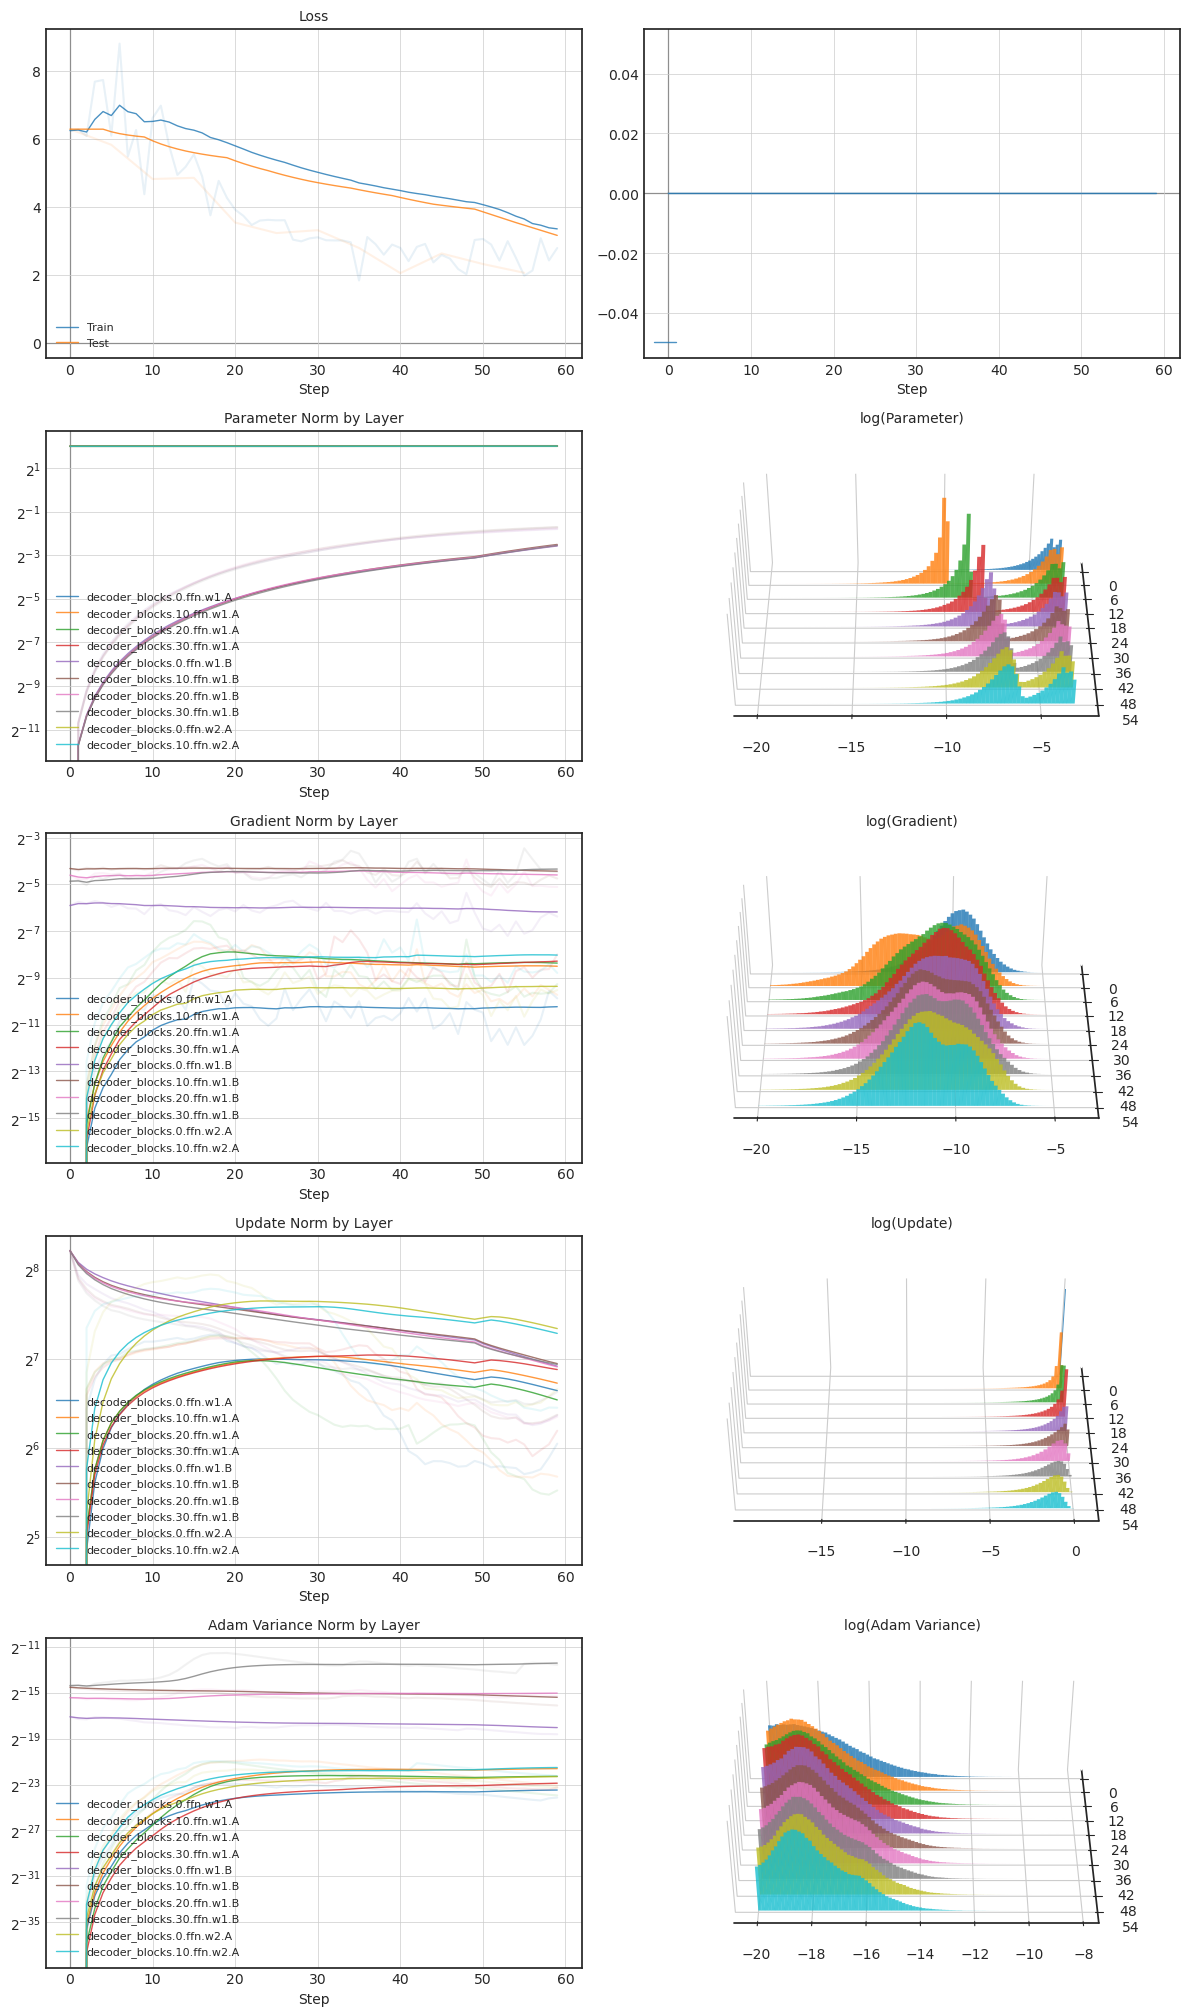

,Response:
Iteration,
0,Hey there! *winks* Last weekend was a blast! I went on a road trip with my buddies to the mountains
20,"Oh, you know, just another weekend of kicking ass and taking names 💪🏼🔥"
40,I think there’s no point in trying to help you with the things I’m worried about 😔 I’m


In [ ]:
for iteration in range(config.ITERATIONS):
    
    model.train()

    try:
        X_batch = next(data_iterator)
    except StopIteration:
        data_iterator = iter(data_loader)
        X_batch = next(data_iterator)
    
    y_batch = X_batch[:, 1:]
    output = model(X_batch)[:, :-1]
    
    # Mask out tokens from the user prompt and any padding, keeping only answer tokens.
    mask = get_answer_token_mask(y_batch)
    loss = F.cross_entropy_loss(output[mask], y_batch[mask])
    loss.backward()
    
    candle.utils.clip_grad_norm_(model.parameters(), max_norm=config.GRAD_CLIP_NORM)
    
    optimizer.step()
    scheduler.step()

    # ----------------
    # Update dashboard
    # ----------------

    model.eval()

    params_to_track = (
        [f'decoder_blocks.{i}.{l}.{ab}'
         for i in range(0, 30, 10)
         for l in ['ffn.w1', 'ffn.w2', 'ffn.w3',
                   'attn.W_k', 'attn.W_q', 'attn.W_v', 'attn.W_o']
         for ab in ['A', 'B']]
    )
    
    (parameters, param_by_layer, param_norm_by_layer) = tutils.get_parameters(params_to_track, model)
    (gradients, grad_by_layer, grad_norm_by_layer) = tutils.get_gradients(params_to_track, model)
    (updates, upd_by_layer, upd_norm_by_layer) = tutils.get_adam_updates(params_to_track, optimizer)
    (adam_var, adam_var_by_layer, adam_var_norm_by_layer) = tutils.get_adam_var(params_to_track, optimizer)
    
    writer.add_scalars('Loss', {'Train': loss.data.item()})
    writer.add_scalars(' ', {' ': 0.0})  # Dummy graph to help with chart alignment
    if iteration % config.EVAL_ITERS == 0:
        test_loss = get_test_loss()
        writer.add_scalars('Loss', {'Test': test_loss}, iteration)
    
    writer.add_scalars('Parameter Norm by Layer', param_norm_by_layer)
    writer.add_histogram('log(Parameter)', np.log(np.abs(parameters) + 1e-10))
    
    writer.add_scalars('Gradient Norm by Layer', grad_norm_by_layer)
    writer.add_histogram('log(Gradient)', np.log(np.abs(gradients) + 1e-10))

    writer.add_scalars('Update Norm by Layer', upd_norm_by_layer)
    writer.add_histogram('log(Update)', np.log(np.abs(updates) + 1e-10))

    writer.add_scalars('Adam Variance Norm by Layer', adam_var_norm_by_layer)
    writer.add_histogram('log(Adam Variance)', np.log(np.abs(adam_var) + 1e-10))
    
    if iteration % config.SAMPLE_GENERATION_ITERS == 0:
        sample_gen_by_iter.loc[iteration, 'Response:'] = generate(SAMPLE_GENERATION_PROMPT)
        
    if iteration % config.DASHBOARD_REFRESH_ITERS == 0:
        writer.plot(clear_output=True)
        
        candle.utils.display_sbs(
            sample_gen_by_iter
            .style
            .set_caption(f'Prompt: "{SAMPLE_GENERATION_PROMPT}"')
            .set_table_styles([
                {'selector': 'caption',
                 'props': [
                     ('font-weight', 'bold'),
                     ('font-size', '14px'),
                     ('text-align', 'center'),
                 ]},
                {'selector': 'th',
                 'props': [('text-align', 'left')]}])
        )

## (5) Chat with JOHNaMA

In [ ]:
USER_NAME = 'John'
ASST_NAME = 'JOHNaMA'

def start_conversation(profile_pic: str = '🙂'):
    gutils.interactive_conversation(
        model, chat_template, tokenizer,
        user_name=USER_NAME,
        profile_pic=profile_pic,
        user_bg_color='yellow',
        asst_name=ASST_NAME,
        asst_profile_pic='👦🏻',
        asst_bg_color='blue',
        max_response_length=2048,
        top_k=100,
        top_p=0.90,
        temperature=0.8,
        stop_token_idx=tokenizer.sp_model.eos_id(),
    )

In [ ]:
start_conversation(profile_pic='👦🏻')